# Discrete Weighting
An exploration of the naive weighting method.

## TLDR
When faced with data imbalance in classification problems, the natural thing to do is to use discrete class weights to enforce class balance. The analogous procedure in regression is to discretize the continuous variable into a set of "classes", and then do discrete weighting on these classes. As the number of "classes" increases, so does the accuracy of weighting. In this notebook, we show how this procedure devolves to continuous class balancing, but has problems in the limit.

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import sklearn
import sys
sys.path.append("../Continuous-Weight-Balancing/")
from weight_balancing import continuous_weight

### Suppose we are trying to predict earthquakes...
Our weight trait might be earthquake magnitude; after all, we care about getting large earthquakes right more than small tremors. Unfortunately, (or fortunately), there are a lot more small earthquakes than large ones, so the distribution of earthquake magnitudes might look something like this

Text(0.5, 1.0, 'Weight Trait')

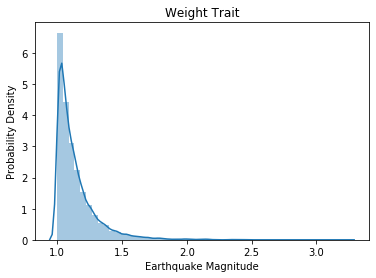

In [2]:
trait = stats.pareto.rvs(8, size=10000)

sns.distplot(trait)
plt.xlabel("Earthquake Magnitude")
plt.ylabel("Probability Density")
plt.title("Weight Trait")

### Suppose we want to weight these examples...
In particular, we want models to place a higher importance on high magnitude earthquakes, and a lower importance on smaller earthquakes. For simplicity, let's assume we want to enforce a uniform $(1, 4)$ distribution after weighting. The naive way to do this is to discretize the weight trait, and then weight those categories accordingly. Let's investigate this

In [9]:
def discrete_weight(trait, bins = 3, limits = (1, 4)):
    """
    This function takes in the trait and a number of discrete categories, bins the data, and then shows the weight distribution and the resultant weighted trait distribution
    """
    
    #clip data to fit in bins
    clipped_trait = trait.clip(limits[0], limits[1])
    #Discretize the trait values
    discrete_trait = np.digitize(clipped_trait, np.linspace(limits[0], limits[1], bins, endpoint=False))
    classes = np.unique(discrete_trait)
    
    #Now get weights
    class_weight = sklearn.utils.class_weight.compute_class_weight("balanced", classes, discrete_trait)
    class_weight = {label : class_weight[i] for i, label in enumerate(classes)}
    weight = np.vectorize(class_weight.get)(discrete_trait)
    
    #Visualize the weights
    plt.figure()
    plt.title('Weights per Trait')
    plt.xlabel("Trait Value")
    plt.ylabel("Weight Value")
    plt.scatter(trait, weight, s=0.5)
    plt.figure()
    plt.title('Weights Per Bucket')
    plt.xlabel("Trait Bucket")
    plt.ylabel("Weight Value")
    plt.bar(class_weight.keys(), class_weight.values())
    
    #Visualize the resultant distribution
    weighted_kde = stats.gaussian_kde(trait, weights = weight)
    weighted_estimate = weighted_kde.evaluate(trait)

    plt.figure(figsize=(8, 6))
    plt.title("Weighted Trait Distribution")
    plt.scatter(trait, weighted_estimate, label="Reweighted Data")
    plt.hlines(y = 1/(limits[1] - limits[0]), xmin=limits[0], xmax=limits[1], colors="r", label = "Target Distribution")
    plt.xlabel("Trait Value")
    plt.ylabel("Weighted Probability Density")
    plt.legend()
    plt.show()

5 bins:


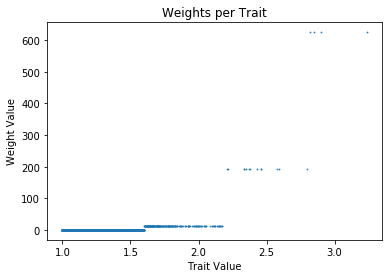

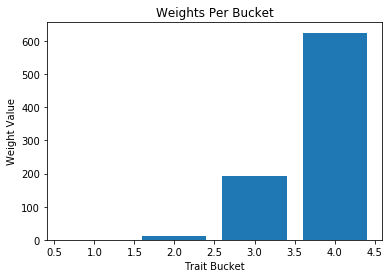

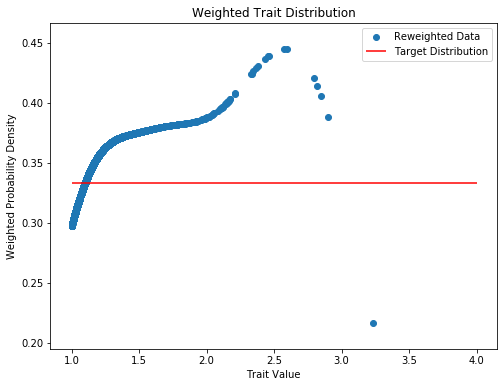

10 bins:


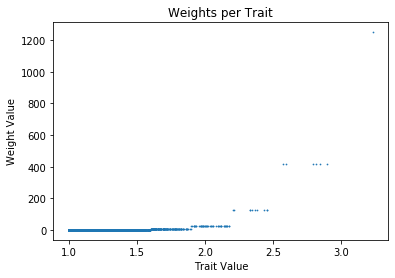

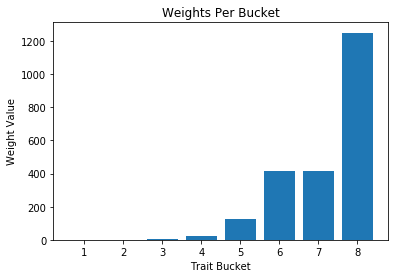

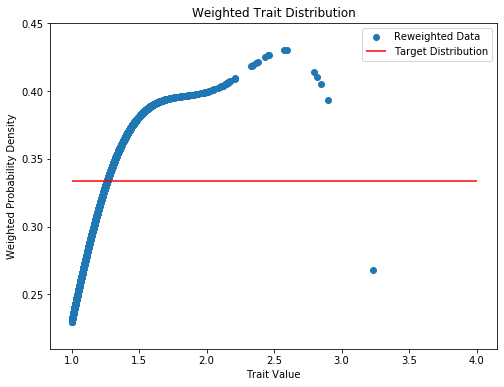

25 bins:


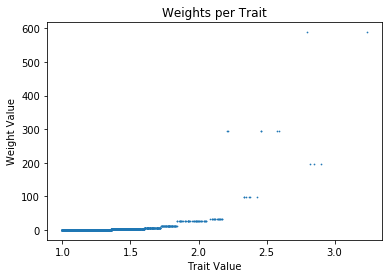

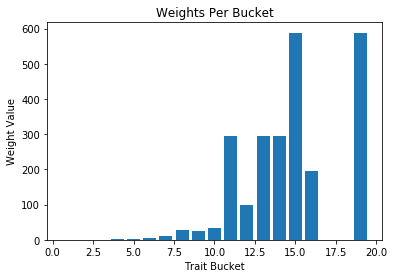

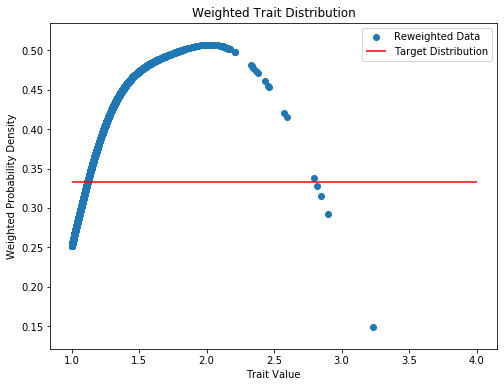

100 bins:


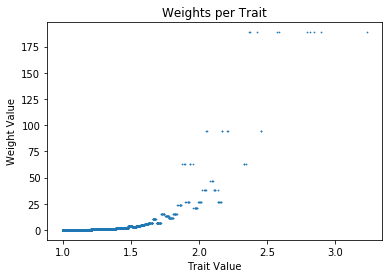

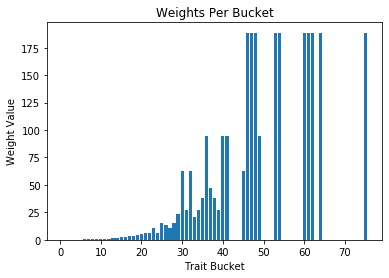

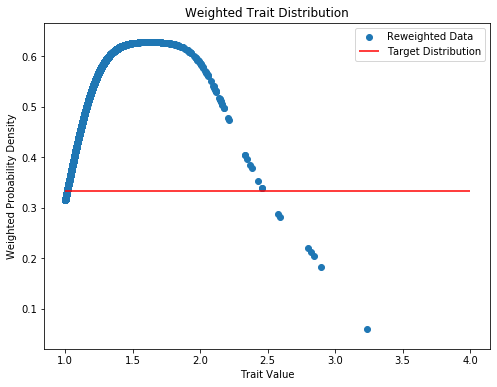

1000 bins:


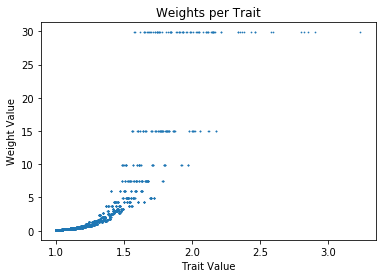

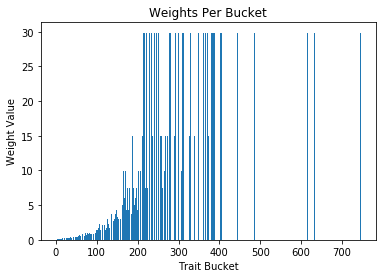

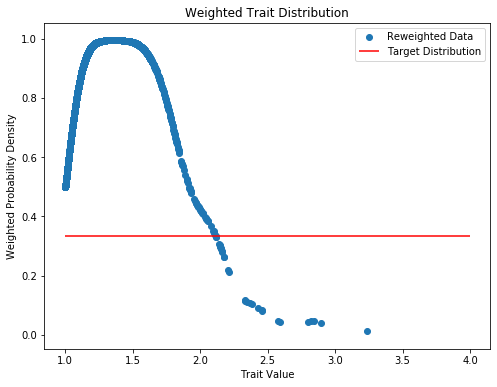

10000 bins:


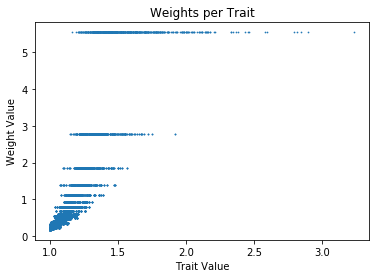

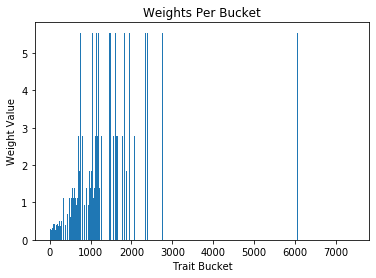

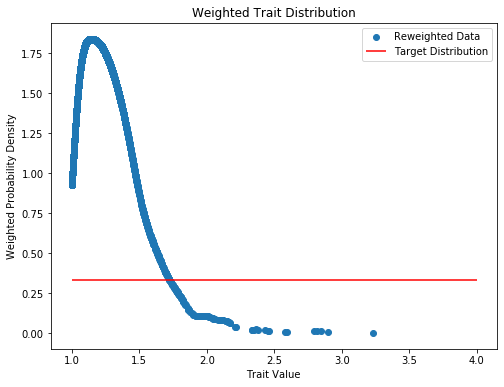

In [17]:
for bin_count in [5, 10, 25, 100, 1000, 10000]:
    print(bin_count, "bins:")
    discrete_weight(trait, bins = bin_count)

# Now, let's compare that to our continuous method

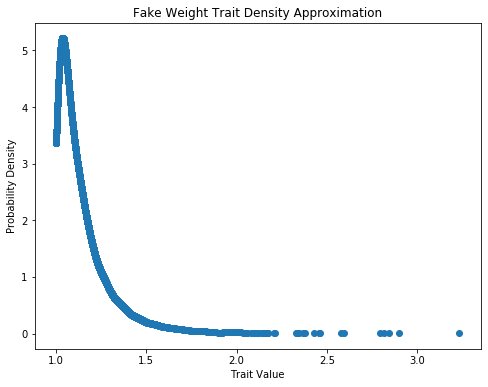

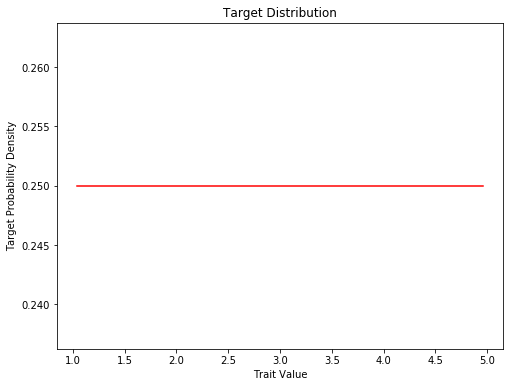

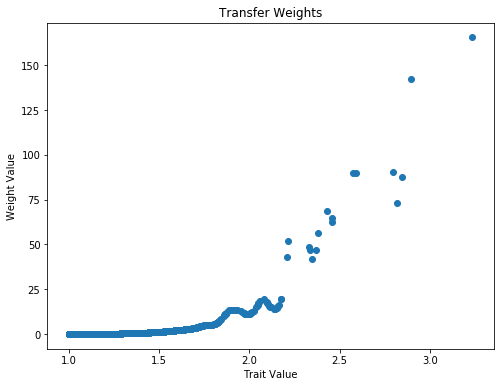

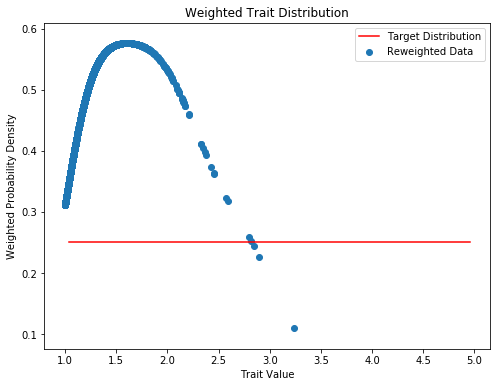

In [15]:
target = stats.uniform(loc = 1, scale = 4)
weights = continuous_weight(trait, target, verbose=True)

## Takeaway
As we can see, discrete weighting converges to uniform weighting, but is stunted by the fact that at extremely high bin counts, most bins have either one or zero samples, leading to degenerate behavior. Our continuous method avoids this behavior, and is also much faster than discrete weighting.